## Text analysis

In [1]:
import pickle as pkl
import matplotlib.pyplot as plt
import random
from random import sample 
import pandas as pd
import seaborn as sns
import numpy as np
import re
from wordcloud import WordCloud
import os
import json
from tqdm import tqdm
import networkx as nx
import pickle
# plot mention matrix
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind

In [2]:
with open(r"LargeData\Graph2.pkl", 'rb') as file:
    graph = pickle.load(file)

In [3]:

flair_list = ["intp","intj","entp","entj","infj","infp","enfj","enfp","istj","isfj","estj","esfj","istp","isfp","estp","esfp"]
extended_flair_list = flair_list + ["submissions"]

mention_dict = {}
id_dict = {}
text_dict = {}
for flair in flair_list:
    temp_dict = {}
    temp_dict_id = {}
    temp_dict_text = {}
    for temp_flair in extended_flair_list:
        temp_dict[temp_flair] = 0
        temp_dict_id[temp_flair] = []
        temp_dict_text[temp_flair] = []
    

    mention_dict[flair] = temp_dict 
    id_dict[flair] = temp_dict_id
    text_dict[flair] = temp_dict_text

for edge in graph.edges:
    author = edge[0]
    addressee = edge[1]

    

    #Check if node is empty
    if graph.nodes[addressee] == {} or graph.nodes[author] == {}:
        continue

    author_flair = graph.nodes[author]['flair']
    addressee_flair = graph.nodes[addressee]['flair']
    if author_flair not in flair_list: 
        continue

    mention_dict[author_flair][addressee_flair] += 1
    id_dict[author_flair][addressee_flair].append(graph.edges[edge]['comment_id'])
    text_dict[author_flair][addressee_flair].append(graph.edges[edge]['comment'])

for node in graph.nodes:
    if graph.nodes[node] == {}: 
        continue
    author_flair = graph.nodes[node]['flair']
    if author_flair not in flair_list: 
        continue
    mention_dict[author_flair]["submissions"] += len(graph.nodes[node]['submissions_id'])
    id_dict[author_flair]["submissions"].extend(graph.nodes[node]['submissions_id'])
    text_dict[author_flair]["submissions"].extend(graph.nodes[node]['submissions'])


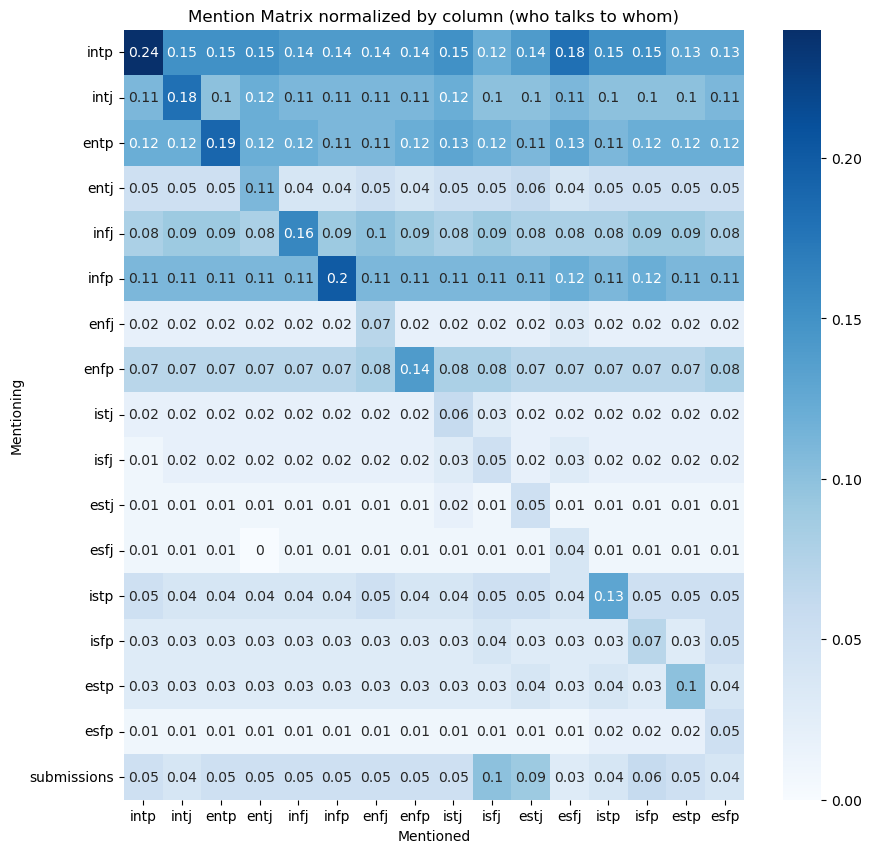

In [4]:
# plot mention matrix

mention_matrix = pd.DataFrame.from_dict(mention_dict)

#normalize by column and round to 2 decimal places
temp_mention_matrix = mention_matrix.div(mention_matrix.sum(axis=0), axis=1).round(2)

plt.figure(figsize=(10,10))
sns.heatmap(temp_mention_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Mention Matrix normalized by column (who talks to whom)')
plt.xlabel('Mentioned')
plt.ylabel('Mentioning')

plt.show()


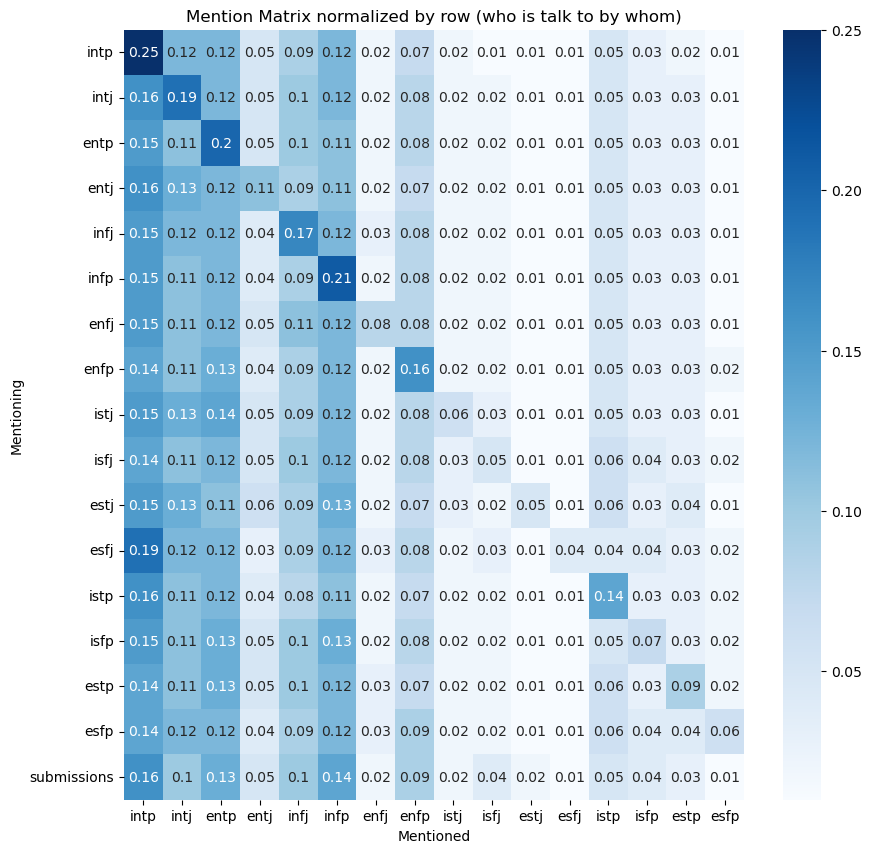

In [5]:
mention_matrix = pd.DataFrame.from_dict(mention_dict)

#normalize by column and round to 2 decimal places
temp_mention_matrix = mention_matrix.div(mention_matrix.sum(axis=1), axis=0).round(2)

plt.figure(figsize=(10,10))
sns.heatmap(temp_mention_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Mention Matrix normalized by row (who is talk to by whom)')
plt.xlabel('Mentioned')
plt.ylabel('Mentioning')

plt.show()

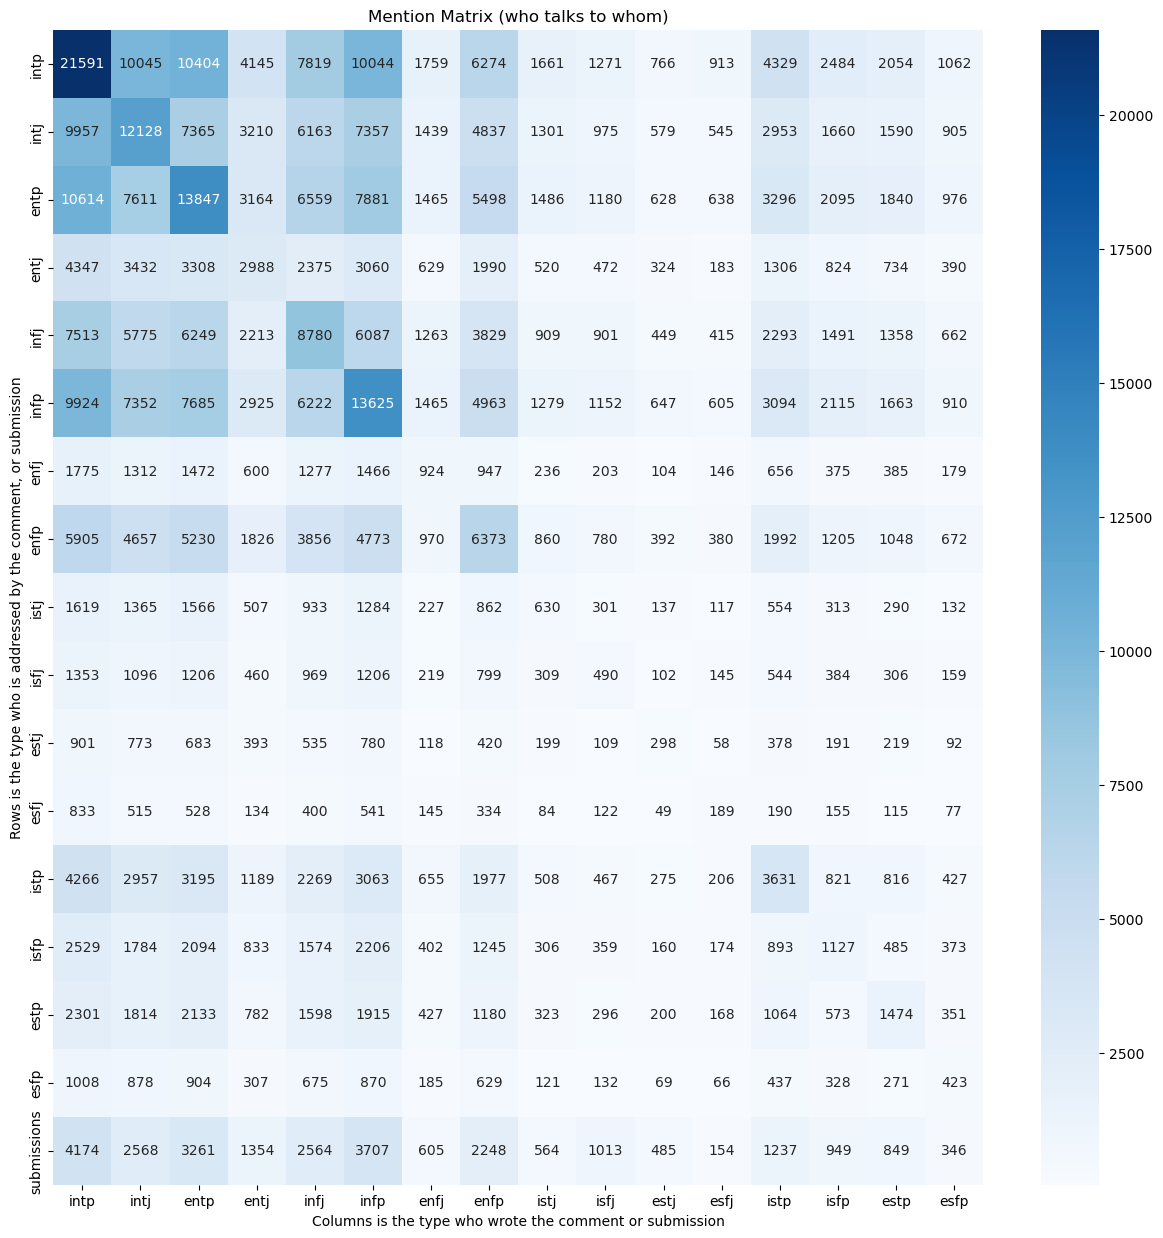

In [6]:
mention_matrix = pd.DataFrame.from_dict(mention_dict)

#normalize by column and round to 2 decimal places

plt.figure(figsize=(15,15))
sns.heatmap(mention_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Mention Matrix (who talks to whom)')
plt.ylabel('Rows is the type who is addressed by the comment, or submission')
plt.xlabel('Columns is the type who wrote the comment or submission')

plt.show()


# Mentioned Sentiment

In [85]:
#Load sentiment dictionary
sentiment_frame=pd.read_csv("sentiment.txt",index_col=0,sep="\t")
sentiment_score=sentiment_frame.to_dict()["happiness_average"]

#Calculate mean sentiment of each post
def calculate_sentiment(text, sentiment_dict):
    sentiment = []
    for doc in text:
        temp_list = [] 
        for word in doc:
            if word in sentiment_dict:
                temp_list.append(sentiment_dict[word])
        if len(temp_list) == 0:
            continue
        else:
            sentiment.append(np.mean(temp_list))
    return sentiment



In [75]:

#Load sentiment dictionary 
sentiment_frame=pd.read_csv("sentiment.txt",index_col=0,sep="\t")
sentiment_score=sentiment_frame.to_dict()["happiness_average"]

#Calculate mean sentiment of each word
def calculate_sentiment(text, sentiment_dict):
    sentiment = []
    for doc in text:
        temp_list = [] 
        for word in doc:
            if word in sentiment_dict:
                temp_list.append(sentiment_dict[word])
        if len(temp_list) == 0:
            continue
        else:
            sentiment.extend(temp_list)
    return sentiment


In [88]:
# Sentiment of each flair
sentiment_list =  []
sem_list = [] 

for flair in flair_list:
    temp_list = []
    for temp_flair in extended_flair_list:
        temp_list.extend(calculate_sentiment(text_dict[flair][temp_flair],sentiment_score))
    
    # Calculate mean sentiment
    sentiment_list.append(np.mean(temp_list))
    
    # Calculate standard error (SEM)
    sem = np.std(temp_list) / np.sqrt(len(temp_list))
    sem_list.append(sem)



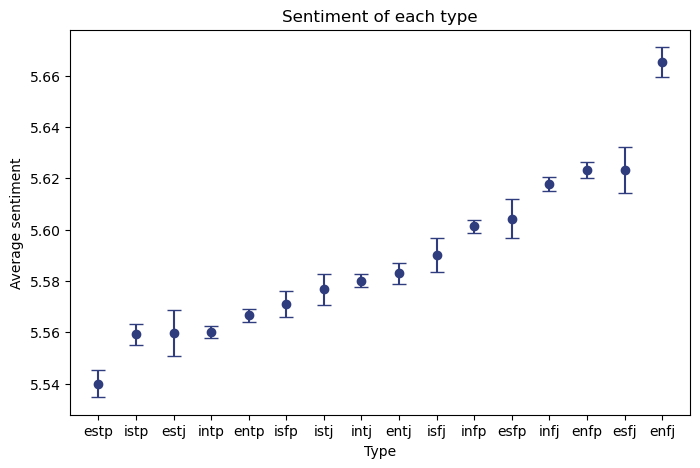

In [89]:

# Make a sorted plot
temp_sentiment_list, tmp_flair_list ,temp_sem_list = zip(*sorted(zip(sentiment_list, flair_list, sem_list)))

# bar plot over sentiment of each flair sorted from highest to lowest
plt.figure(figsize=(8,5))



plt.errorbar(tmp_flair_list, temp_sentiment_list,yerr=temp_sem_list, color="#2F3C7E", fmt='o', capsize=5)
plt.title("Sentiment of each type")
plt.ylabel("Average sentiment")
plt.xlabel("Type")
plt.show()

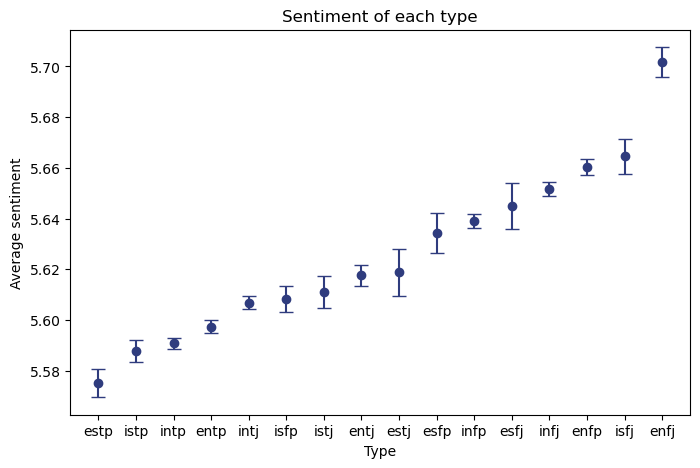

In [80]:

# Make a sorted plot
temp_sentiment_list, tmp_flair_list ,temp_sem_list = zip(*sorted(zip(sentiment_list, flair_list, sem_list)))

# bar plot over sentiment of each flair sorted from highest to lowest
plt.figure(figsize=(8,5))

#Rescale y axis


plt.errorbar(tmp_flair_list, temp_sentiment_list,yerr=temp_sem_list, color="#2F3C7E", fmt='o', capsize=5)
plt.title("Sentiment of each type")
plt.ylabel("Average sentiment")
plt.xlabel("Type")
plt.show()

# Investaget sentiment between letters

In [32]:
from scipy.stats import ttest_ind


In [50]:
F_sentiment_list =  []
for flair in ["infj","infp","enfj","enfp","isfj","isfp","esfj","esfp"]:
    temp_list = []
    for temp_flair in extended_flair_list:
        F_sentiment_list.extend(calculate_sentiment(text_dict[flair][temp_flair],sentiment_score))

T_sentiment_list =  []
for flair in ["intp","intj","entp","entj","istj","istp","estj","estp"]:
    temp_list = []
    for temp_flair in extended_flair_list:
        T_sentiment_list.extend(calculate_sentiment(text_dict[flair][temp_flair],sentiment_score))

print("F vs T")
print(ttest_ind(F_sentiment_list, T_sentiment_list,equal_var=False))

S_sentiment_list =  []
for flair in ["estp","estj","esfp","esfj","isfp","isfj","isfp","isfj"]:
    temp_list = []
    for temp_flair in extended_flair_list:
        S_sentiment_list.extend(calculate_sentiment(text_dict[flair][temp_flair],sentiment_score))

N_sentiment_list =  []
for flair in ["intp","intj","entp","entj","infj","infp","enfj","enfp"]:
    temp_list = []
    for temp_flair in extended_flair_list:
        N_sentiment_list.extend(calculate_sentiment(text_dict[flair][temp_flair],sentiment_score))

print("S vs N")
print(ttest_ind(S_sentiment_list, N_sentiment_list,equal_var=False))

J_sentiment_list =  []
for flair in ["intj","infj","entj","enfj","istj","isfj","estj","esfj"]:
    temp_list = []
    for temp_flair in extended_flair_list:
        J_sentiment_list.extend(calculate_sentiment(text_dict[flair][temp_flair],sentiment_score))

P_sentiment_list =  []
for flair in ["intp","infp","entp","enfp","istp","isfp","estp","esfp"]:
    temp_list = []
    for temp_flair in extended_flair_list:
        P_sentiment_list.extend(calculate_sentiment(text_dict[flair][temp_flair],sentiment_score))

print("J vs P")
print(ttest_ind(J_sentiment_list, P_sentiment_list,equal_var=False))

E_sentiment_list =  []
for flair in ["entp","entj","enfp","enfj","estp","estj","esfp","esfj"]:
    temp_list = []
    for temp_flair in extended_flair_list:
        E_sentiment_list.extend(calculate_sentiment(text_dict[flair][temp_flair],sentiment_score))

I_sentiment_list =  []
for flair in ["intp","intj","infp","infj","istp","istj","isfp","isfj"]:
    temp_list = []
    for temp_flair in extended_flair_list:
        I_sentiment_list.extend(calculate_sentiment(text_dict[flair][temp_flair],sentiment_score))
print("E vs I")
print(ttest_ind(E_sentiment_list, I_sentiment_list,equal_var=False))
    



F vs T
TtestResult(statistic=23.940909468223147, pvalue=1.3750791824108301e-126, df=458814.49807708274)
S vs N
TtestResult(statistic=-5.588338690278099, pvalue=2.2974147077679296e-08, df=121574.68950034963)
J vs P
TtestResult(statistic=10.255238359392246, pvalue=1.1291433536184923e-24, df=388756.4002069307)
E vs I
TtestResult(statistic=3.429484412515519, pvalue=0.0006047952375807319, df=369034.7005057102)


In [ ]:
ttest_ind(S_sentiment_list, N_sentiment_list)

TtestResult(statistic=-82.05245678898288, pvalue=0.0, df=23468988.0)

In [64]:
#Make sentiment dictionary
sentiment_dict = {}
for flair in flair_list:
    temp_dict = {}
    for temp_flair in extended_flair_list:
        temp_dict[temp_flair] = np.mean(calculate_sentiment(text_dict[flair][temp_flair],sentiment_score)) 
    sentiment_dict[flair] = temp_dict

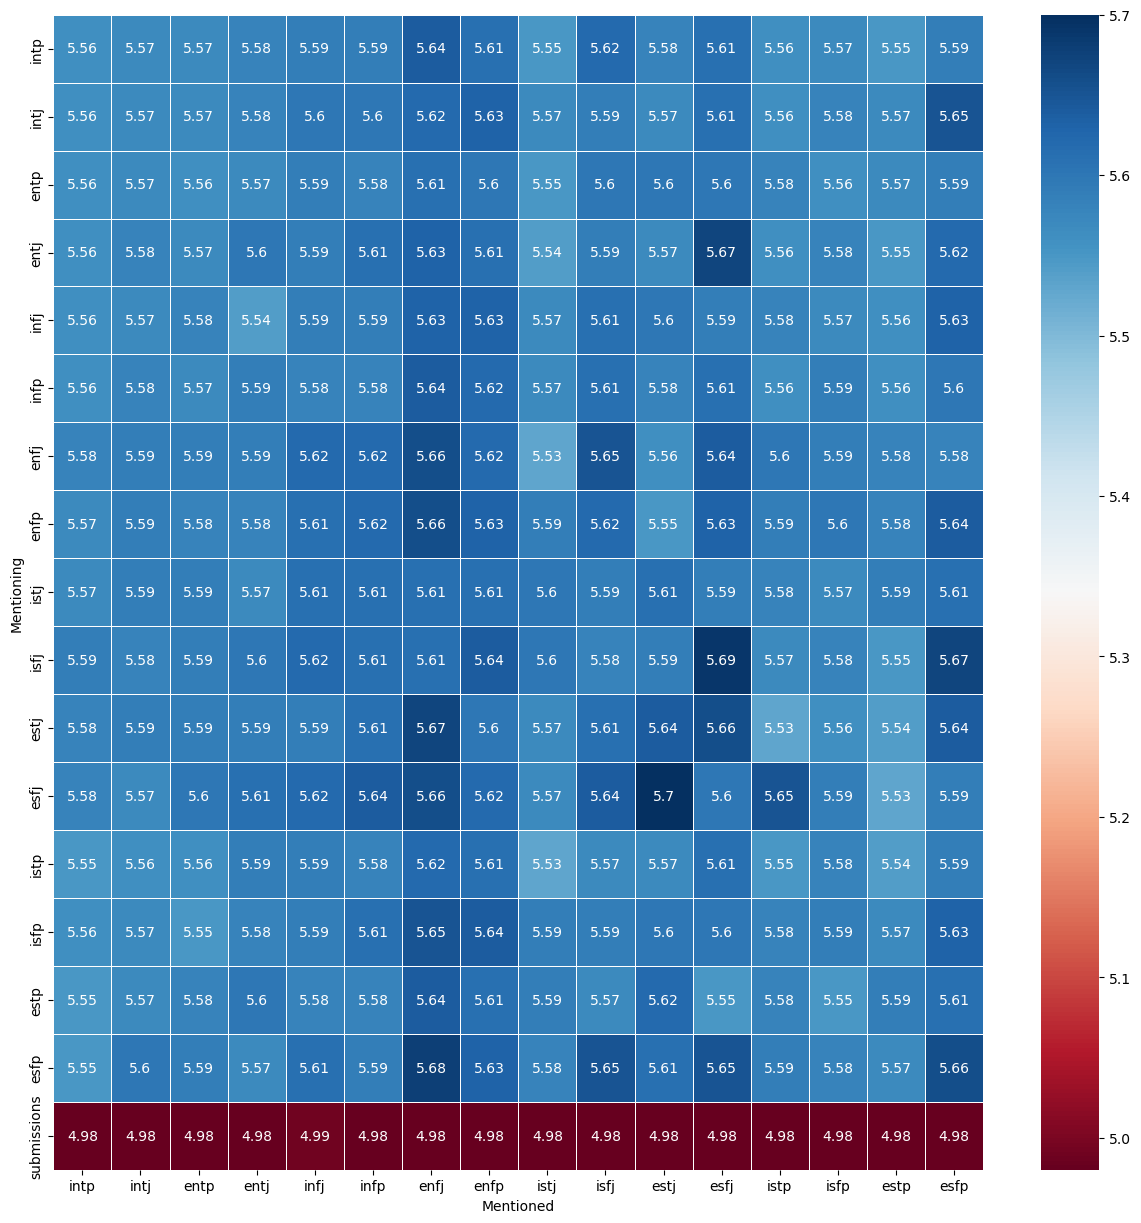

In [84]:
# plot mention matrix
import seaborn as sns
import matplotlib.pyplot as plt

mention_matrix = pd.DataFrame.from_dict(sentiment_dict)

#Subtract mean sentiment of each flair from each cell
#for flair in flair_list:
#    mention_matrix[flair] = mention_matrix[flair] - sentiment_list[flair_list.index(flair)]


mention_matrix = mention_matrix.round(2)

plt.figure(figsize=(15,15))

sns.heatmap(mention_matrix, annot=True, fmt='g', cmap='RdBu', linewidth=.5)
plt.xlabel('Mentioned')
plt.ylabel('Mentioning')

plt.show()

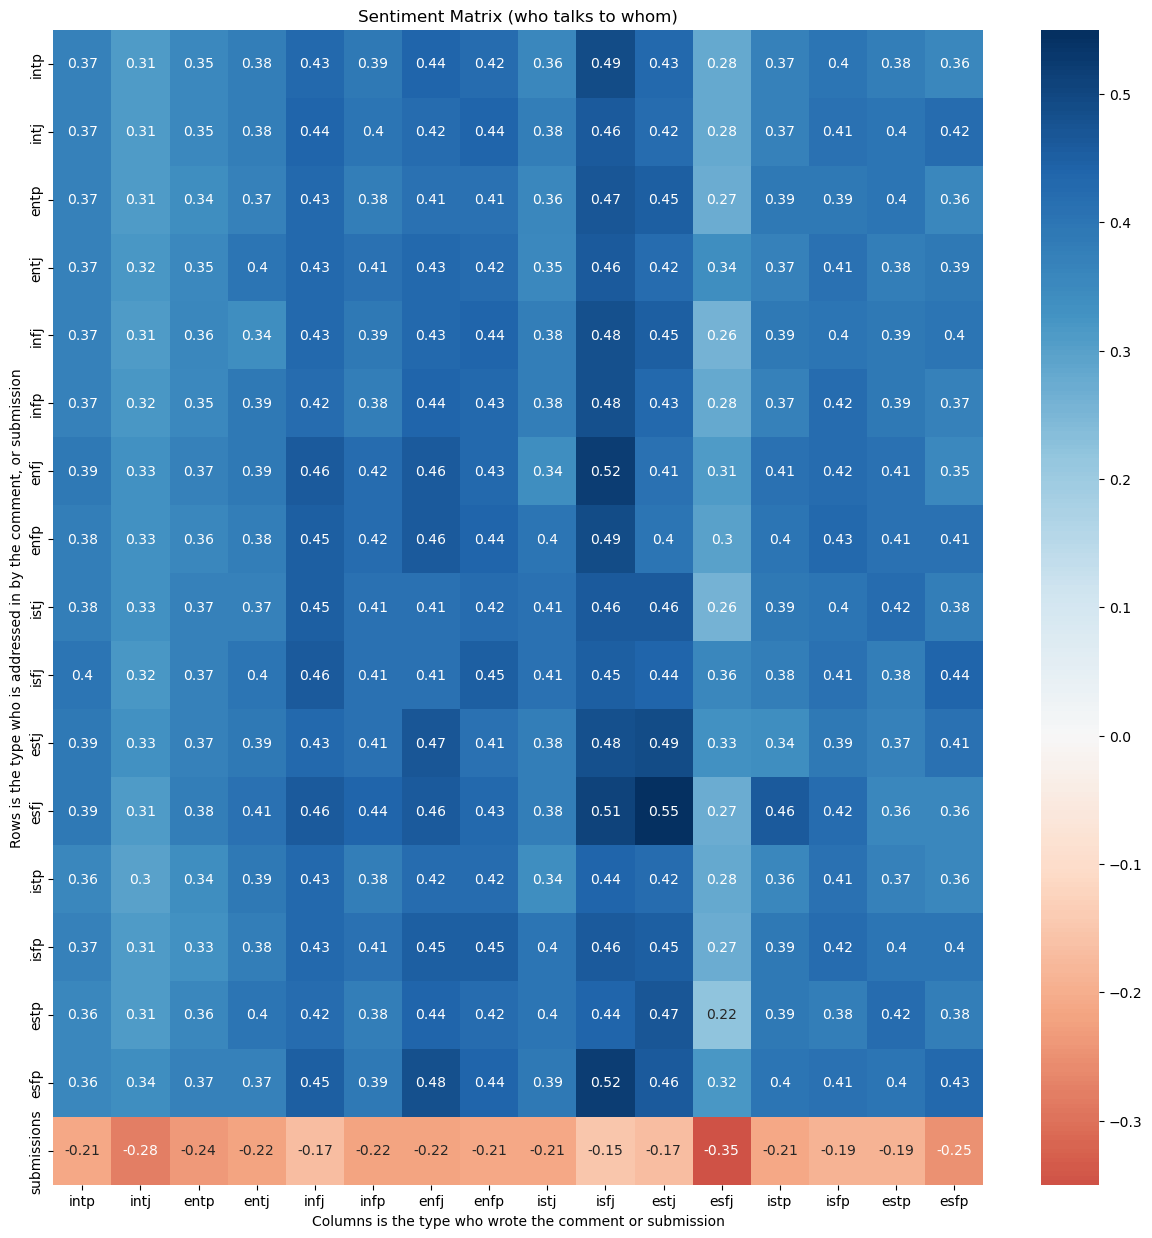

In [67]:
# plot mention matrix
import seaborn as sns
import matplotlib.pyplot as plt

mention_matrix = pd.DataFrame.from_dict(sentiment_dict)

mention_matrix = mention_matrix.round(2)


#Subtract mean sentiment of each flair from each cell
for flair in flair_list:
    mention_matrix[flair] = mention_matrix[flair] - sentiment_list[flair_list.index(flair)]

#mention_matrix = mention_matrix.subtract(mention_matrix.mean(axis=0), axis=1)

mention_matrix = mention_matrix.round(2)

plt.figure(figsize=(15,15))

sns.heatmap(mention_matrix, annot=True, fmt='g', cmap='RdBu', center=0)
plt.title('Sentiment Matrix (who talks to whom)')
plt.ylabel('Rows is the type who is addressed in by the comment, or submission')
plt.xlabel('Columns is the type who wrote the comment or submission')

plt.show()

# Word cloud what is said

In [17]:
flair_list = ["intp","intj","entp","entj","infj","infp","enfj","enfp","istj","isfj","estj","esfj","istp","isfp","estp","esfp"]

mention_dict = {}
for flair in flair_list:
    temp_dict = {}
    for temp_flair in flair_list:
        temp_dict[temp_flair] = []
    mention_dict[flair] = temp_dict 

with open('links2022_clean' + '.ndjson',"r", encoding='utf-8') as f:
    for line in tqdm(f):
        post=json.loads(line)
        flair = post["flair"]
        comment = post["comment"]
        for word in comment:
            if word in flair_list:
                mention_dict[flair][word] += post["comment"]

FileNotFoundError: [Errno 2] No such file or directory: 'links2022_clean.ndjson'

In [ ]:
#Select talking flair
flair = "esfp"

word_dict = mention_dict[flair]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
names = list(word_dict.keys())
tf_idf= vectorizer .fit_transform([' '.join(list) for list in word_dict.values()])
word_list = vectorizer.get_feature_names_out()

In [ ]:
def tf_idf_to_string(tf_idf_matrix, word_list):
    feature_index = tf_idf_matrix.nonzero()[1]
    tfidf_scores = [(word_list[i], tf_idf_matrix[0, i]) for i in feature_index]
    tf_idf_string = ''
    for word, score in tfidf_scores:
        tf_idf_string += (word + ' ') * int(score * 100)  # Multiplying by 10 for better visualization
    return tf_idf_string

data_for_wordcloud = []
for i in range(16):
    data_for_wordcloud.append(tf_idf_to_string(tf_idf[i, :], word_list))

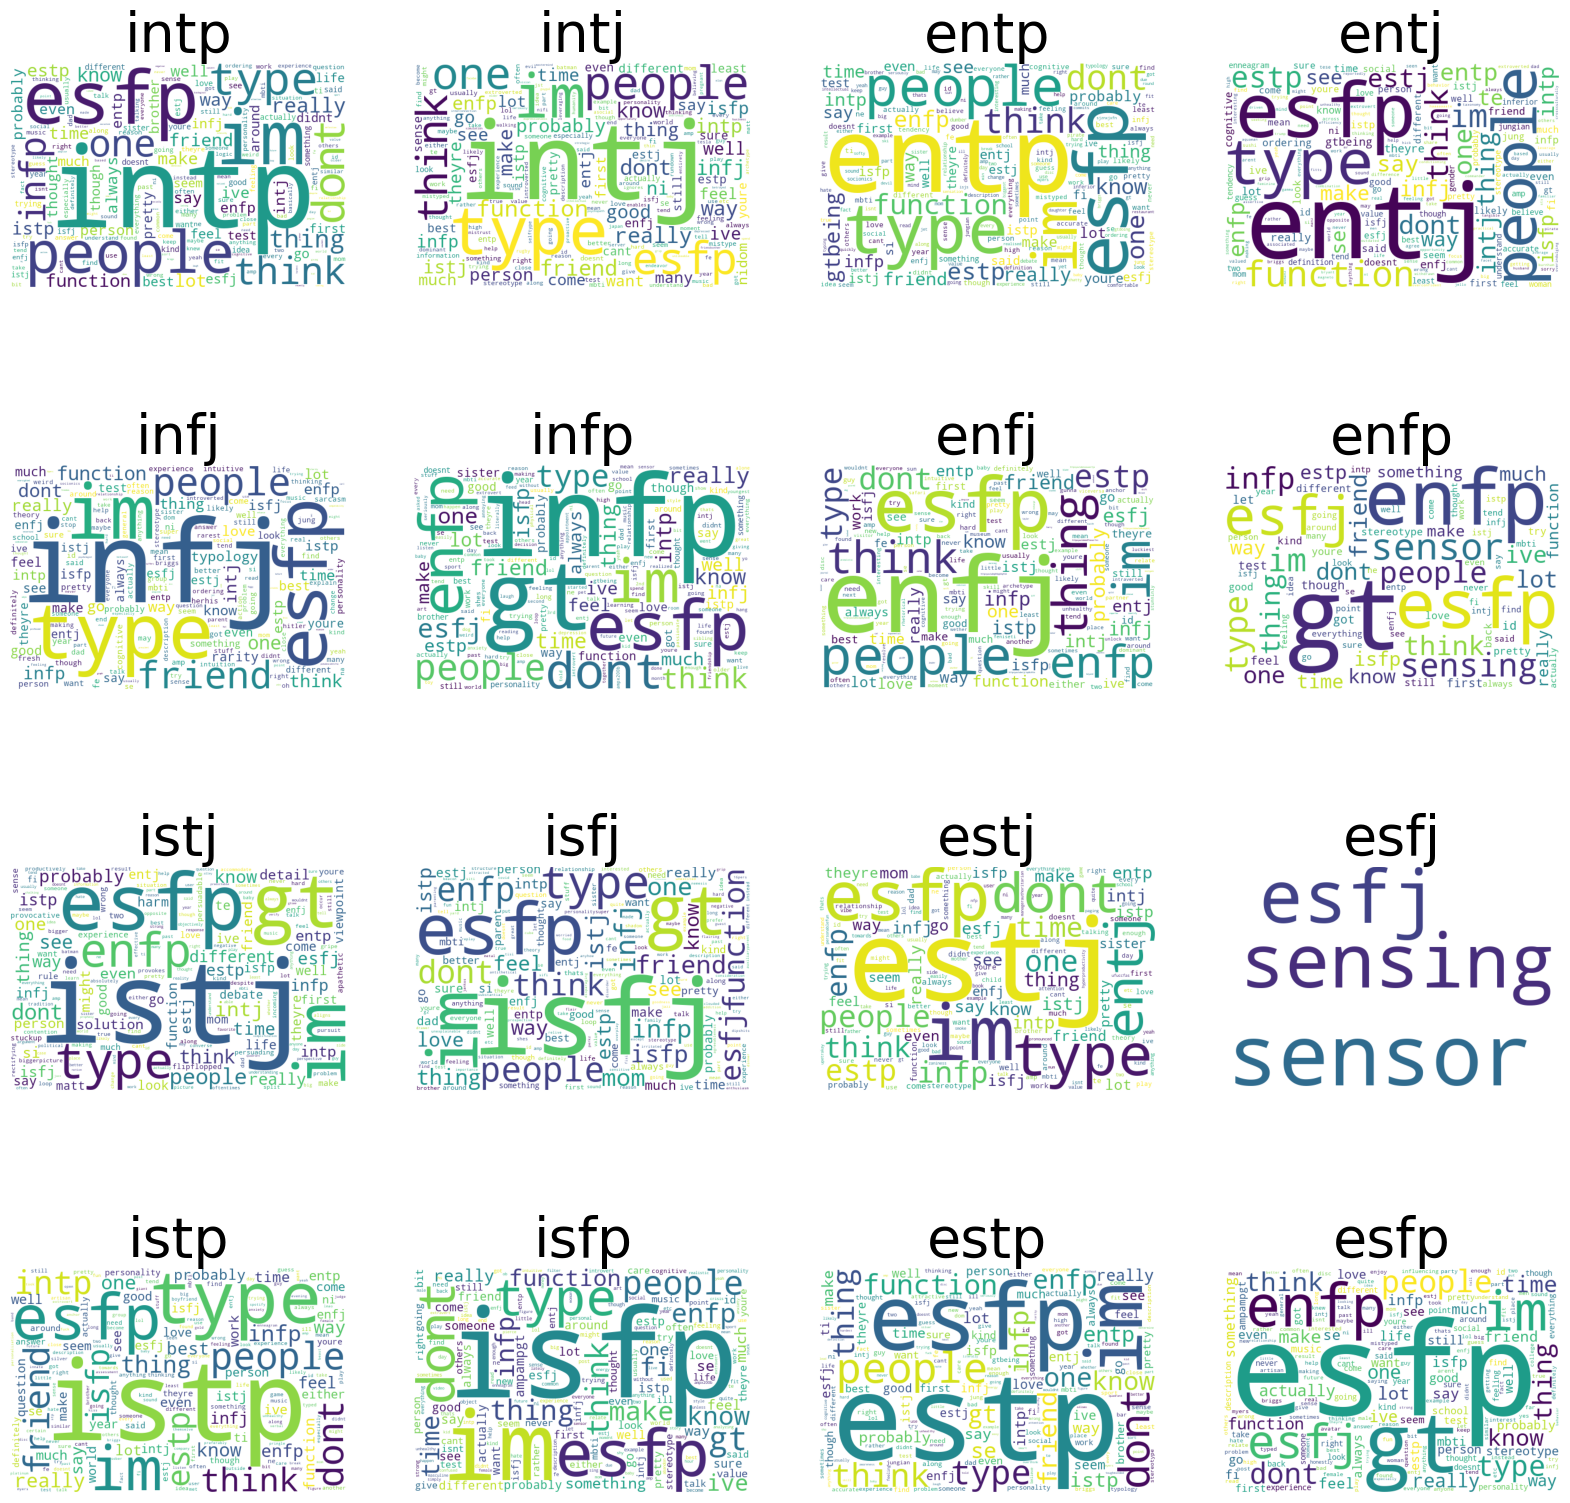

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=[20, 20])
for i in range(4):
    for j in range(4):

        wordcloud = WordCloud(background_color='white', width=600, height=400,collocations=False).generate(data_for_wordcloud[4*i+j])
        ax[i,j].imshow(wordcloud)
        ax[i,j].axis('off')
        ax[i,j].set_title(names[4*i+j],fontsize=40)
plt.show()

In [ ]:
author = "type-special"
adressed = "istj"
texts=mention_dict[flair][adressed]
print(" ".join(texts))

TypeError: can only join an iterable

# Arvage length of comment

In [ ]:
with open(r"LargeData\Graph.pkl", 'rb') as file:
    graph = pickle.load(file)

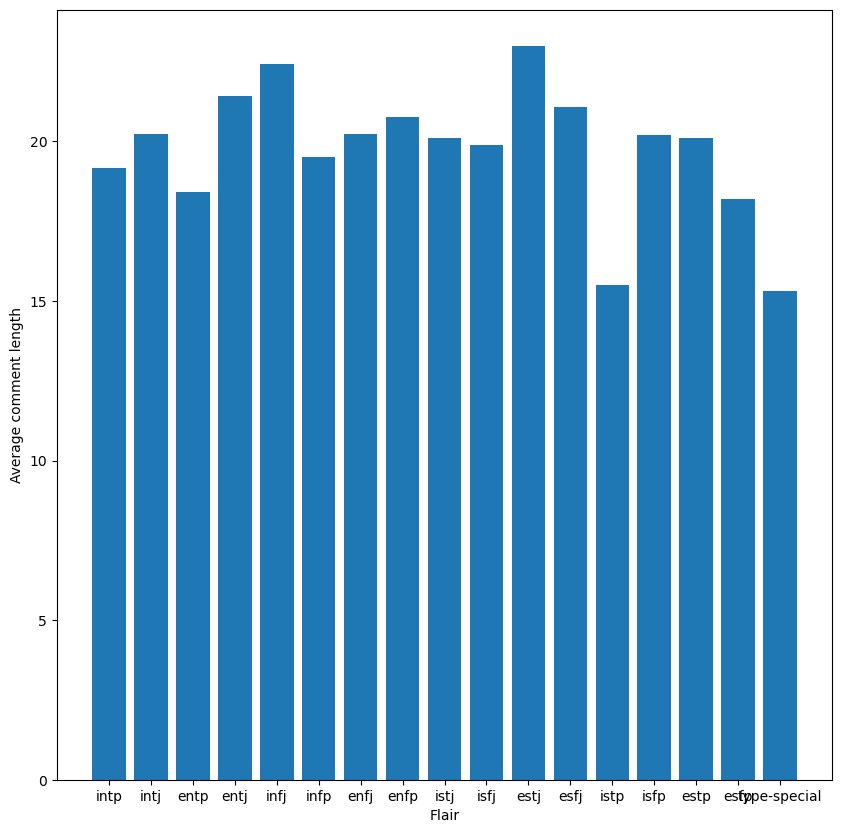

In [ ]:
for flair in flair_list:

    mention_dict[flair] = []

for node in graph.nodes:
    if graph.nodes[node] == {}:
        continue
    flair = graph.nodes[node]["flair"]
    mention_dict[flair]+=[len(comment) for comment in graph.nodes[node]["comments"]]

len_list=[]
for flair in flair_list:
    len_list.append(np.mean(mention_dict[flair]))

plt.figure(figsize=(10,10))
plt.bar(flair_list,len_list)
plt.xlabel('Flair')
plt.ylabel('Average comment length')
plt.show()

